# Efecto de régimen de dosificación en PTA

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from keras.wrappers.scikit_learn import KerasRegressor

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
import pandas as pd

from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import datasets

In [2]:
!pip install eli5
!pip install shap
import eli5
from eli5.sklearn import PermutationImportance
import shap

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



In [3]:
data = pd.read_csv('evaluacionRegimenes.csv')
data.head()

,DD,II,CLCR,tinf,AUC_target,cmin_target
0,15.926526,16.382515,122.393621,10.371416,0.01,0.000
1,27.707732,17.707842,132.087299,10.349899,0.32,0.020
2,16.171664,6.996703,85.726831,2.071341,0.04,0.010
3,17.432043,19.810702,133.081308,7.248445,0.00,0.000
4,23.299946,16.779880,141.393789,15.036658,0.07,0.055


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DD           5000 non-null   float64
 1   II           5000 non-null   float64
 2   CLCR         5000 non-null   float64
 3   tinf         5000 non-null   float64
 4   AUC_target   5000 non-null   float64
 5   cmin_target  5000 non-null   float64
dtypes: float64(6)
memory usage: 234.5 KB


Se seleccionan a las variables `DD`, `ii`, `tinf`, `CLCR`, y `MIC`, como variables dependientes, se conoce por gráficos marginales que `ii`, `tinf`, y `CLCR` aportan poca información sobre el indicador PK-PD reportado en la columna `mn` (AUC/MIC >= 400).

In [5]:
X  = data.loc[:, ['DD', 'II', 'tinf', 'CLCR']]
y1 = data.AUC_target
y2 = data.cmin_target
Y  = np.array([y1.ravel(), y2.ravel()]).T

In [6]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

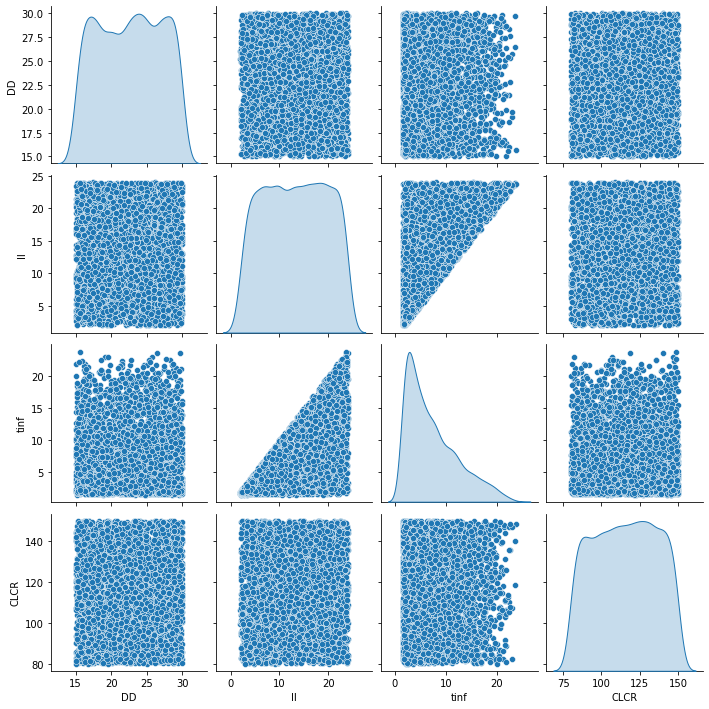

In [8]:
sns.pairplot(X_train, diag_kind='kde');

## Modelo
Ahora se especifica la configuración de la red neuronal artificial, mediante la librería `Keras`.

In [9]:
def regresorKeras():
  # Inicio de modelo
  model = tf.keras.models.Sequential([normalizer])
  # Capa de entrada
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(X_train.shape[1],)))
  # Capas ocultas
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
  # Capa de salida
  # Se seleccionan dos neuronas de salida: indicador: AUC/MIC > 400 & <600, Cmin entre 15 y 20mg/L
  # La capa de salida sólo permite valores de 0 a 1 se usa fun sigmoidea
  model.add(tf.keras.layers.Dense(2, activation = tf.nn.sigmoid)) 
  
  model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = 'mean_absolute_error')
  return model; 

In [10]:
regresorKeras().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 301
Trainable params: 292
Non-trainable params: 9
_________________________________________________________________


In [11]:
estimator = KerasRegressor(build_fn=regresorKeras, 
                           batch_size=32, epochs=60, 
                           validation_data=(X_test.values, y_test),
                           verbose=0)

history = estimator.fit(X_train.values, y_train)

In [12]:
histDF = pd.DataFrame(history.history)
histDF['epoch'] = history.epoch
histDF.tail()

,loss,val_loss,epoch
55,0.016505,0.015487,55
56,0.016497,0.014955,56
57,0.016179,0.014787,57
58,0.016418,0.015894,58
59,0.016821,0.015119,59


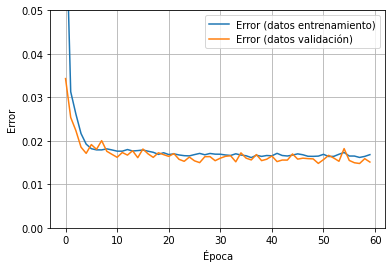

In [13]:
plt.plot(history.history['loss'], label='Error (datos entrenamiento)')
plt.plot(history.history['val_loss'], label='Error (datos validación)')
plt.ylim([0, 0.05])
plt.xlabel('Época')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.savefig('./020_Error_Enternamiento.pdf')

In [14]:
def expand_grid(x, y, xval = 'x', yval = 'y'):
    xG, yG = np.meshgrid(x, y) # Crear malla
    xG = xG.flatten() # Hacer malla 1D
    yG = yG.flatten() # Igual
    return pd.DataFrame({xval:xG, yval:yG})

In [15]:
def PTAColorScalePlotly(color1 = 'rgb(3,148, 252)', color2 = 'rgb(255,32,3)', umbral=0.85):
  return [(0.00, color1), (umbral, color1), (umbral, color2), (1.00, color2)]

In [16]:
# sampleDF = expand_grid(np.linspace(-6, 6), np.linspace(15, 30), xval = 'MIC', yval = 'DD')
# sampleDF['ii'] = 6
# sampleDF['tinf'] = 2
# sampleDF['CLCR'] = 120
# sampleDF = sampleDF[['DD', 'ii', 'tinf', 'CLCR', 'MIC']]

In [17]:
objetoDict = {
  'DD': np.linspace(15, 30),
  'CLCR': np.linspace(80, 150),
  'ii': 6,
  'tinf': 2
}

ordenLista = ['DD', 'ii', 'tinf', 'CLCR']

def simularANN(variables, modelo, orden = ordenLista):
  dictArray  = [(i,k) for (i,k) in variables.items() if type(k) == np.ndarray]
  floatArray = [(i,k) for (i,k) in variables.items() if type(k) != np.ndarray]

  if len(dictArray) > 2:
    return
  
  sampleDF = expand_grid(dictArray[0][1], 
                        dictArray[1][1], 
                        xval = dictArray[0][0], 
                        yval = dictArray[1][0])

  for i in range(len(floatArray)):
    var, val = floatArray[i];
    sampleDF[var] = val

  sampleDF = sampleDF[orden]
  resultados = {'x': dictArray[0], 'y': dictArray[1], 'z': modelo.predict(sampleDF)}
  return resultados

In [18]:
DF = simularANN(objetoDict, estimator, ordenLista)

In [19]:
fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/kg/dia)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 2, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = DF['x'][1],
    y = DF['y'][1],
    z = DF['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, DF['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = DF['x'][1],
    y = DF['y'][1],
    z = DF['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, DF['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q6h, tinf=2')

fig.show()

fig.write_html("021_superficiePTA_dosis_MIC1.html")

In [20]:
def PTAColorScaleMatplotlib(color1 = "#0394fc", color2 = "#ff2103", umbral=0.85):
  cmap = ListedColormap([color1, color1, color2, color2])
  bounds = [0.0, umbral, 1.0]
  norm = BoundaryNorm(bounds, cmap.N)

  return {'cmap': cmap, 'bounds': bounds, 'norm': norm}

In [21]:
def grafico3DSuperficie(x, y, z, newcmp, xlab = '', ylab = '', zlab = '', 
                        lim_opt = {'xlab': [-6, +6], 'ylab': [15,30], 'zlab': [0,1]}, 
                        view_init_opt = {'elev': 10, 'azim': 12}):
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  
  x1, y1 = np.meshgrid(x, y)

  ax.plot_surface(x1, y1, z, cmap=newcmp, linewidth=0, antialiased=False)
  ax.set_xlim(lim_opt['xlab'][0], lim_opt['xlab'][1])
  ax.set_ylim(lim_opt['ylab'][0], lim_opt['ylab'][1])
  ax.set_zlim(lim_opt['zlab'][0], lim_opt['zlab'][1])
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_zlabel(zlab)
  ax.view_init(elev = view_init_opt['elev'], azim = view_init_opt['azim']);
  return fig;

In [22]:
def grafico3DContorno(ax, x, y, z, cmap, xlab = '', ylab = '', title='', levels = [0.0, 0.85, 1.00]):
  
  x1, y1 = np.meshgrid(x, y)
  main = ax.contourf(x1, y1, z, levels = levels, cmap=cmap, 
                     #vmax=1, vmin=0
                     )
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_title(title)

  return main;

In [23]:
df = simularANN({'DD': np.linspace(15, 30), 'CLCR': np.linspace(80, 150), 'ii': 12, 'tinf': 4}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/kg/dia)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 2, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q6h, tinf=4')

fig.show()

In [24]:
fig.write_html("022_superficiePTA_dosis_MIC2.html")

In [25]:
df = simularANN({'DD': np.linspace(15, 30), 'CLCR': np.linspace(80, 150), 'ii': 12, 'tinf': 8}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/kg/dia)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 2, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q6h, tinf=8')

fig.show()

In [26]:
fig.write_html("023_superficiePTA_dosis_MIC3.html")

In [27]:
df = simularANN({'DD': np.linspace(15, 30), 'CLCR': np.linspace(80, 150), 'ii': 12, 'tinf': 12}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/kg/dia)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 2, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q12h, tinf=12')

fig.show()

In [28]:
fig.write_html("024_superficiePTA_dosis_MIC4.html")

In [29]:
df = simularANN({'DD': np.linspace(15, 30), 'CLCR': np.linspace(80, 150), 'ii': 24, 'tinf': 24}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/kg/dia)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 2, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q24h, tinf=24')

fig.show()

In [30]:
fig.write_html("025_superficiePTA_dosis_MIC5.html")

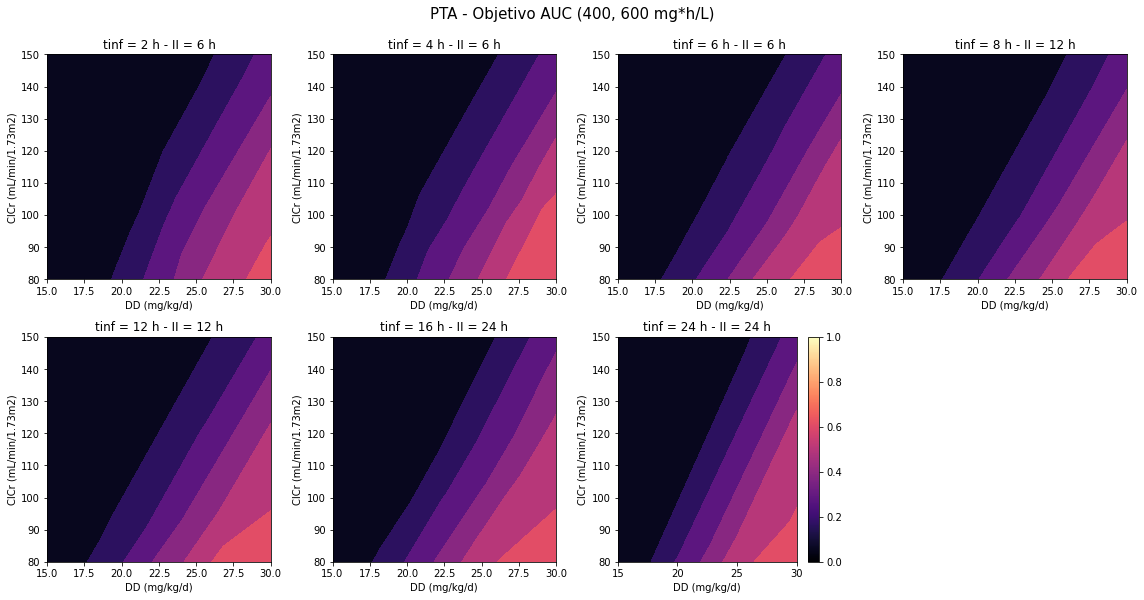

In [31]:
fig = plt.figure(figsize=(16,8))

colscal = PTAColorScaleMatplotlib(umbral=0.85)

tinf_c = [2, 4, 6, 8, 12, 16, 24]
ii_c   = [6, 6, 6, 12, 12,24, 24]

# Cambio de la dosis diaria
for i, (j, k) in enumerate(zip(tinf_c, ii_c)):
  ax = plt.subplot(2,4, i+1)
  
  df = simularANN({'DD': np.linspace(15, 30, 500), 'CLCR': np.linspace(80, 150, 500), 'ii': k, 'tinf': j}, estimator, ordenLista)

  grafico3DContorno(ax, df['x'][1], df['y'][1], df['z'][:, 0].reshape((500, 500)), plt.get_cmap('magma'),
                    'DD (mg/kg/d)', 'ClCr (mL/min/1.73m2)', 'tinf = {0} h - II = {1} h'.format(j, k), levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
  # ax[i].vlines(0, 90, 150, linestyle='dashed')

plt.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('magma')));
fig.set_tight_layout(True)
fig.suptitle('PTA - Objetivo AUC (400, 600 mg*h/L)\n', va = 'bottom', size=15); 
plt.savefig('026_superficiePTA_CLCR_DD_PTA1.pdf')

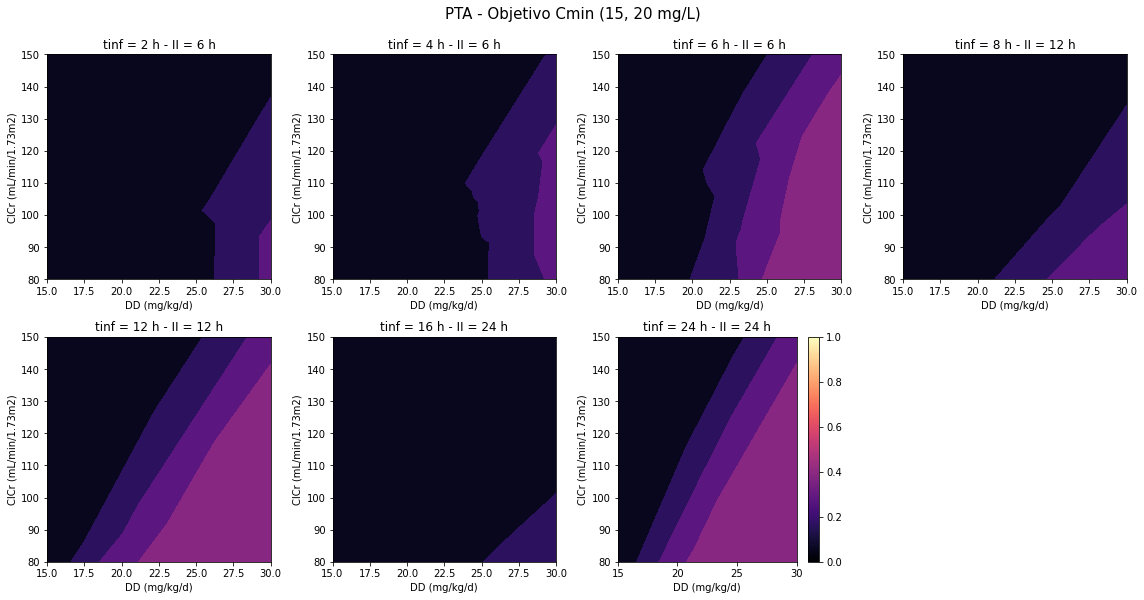

In [32]:
fig = plt.figure(figsize=(16,8))

colscal = PTAColorScaleMatplotlib(umbral=0.85)

tinf_c = [2, 4, 6, 8, 12, 16, 24]
ii_c   = [6, 6, 6, 12, 12,24, 24]

# Cambio de la dosis diaria
for i, (j, k) in enumerate(zip(tinf_c, ii_c)):
  ax = plt.subplot(2,4, i+1)
  
  df = simularANN({'DD': np.linspace(15, 30, 500), 'CLCR': np.linspace(80, 150, 500), 'ii': k, 'tinf': j}, estimator, ordenLista)

  grafico3DContorno(ax, df['x'][1], df['y'][1], df['z'][:, 1].reshape((500, 500)), plt.get_cmap('magma'),
                    'DD (mg/kg/d)', 'ClCr (mL/min/1.73m2)', 'tinf = {0} h - II = {1} h'.format(j, k), levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
  # ax[i].vlines(0, 90, 150, linestyle='dashed')

plt.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('magma')));
fig.set_tight_layout(True)
fig.suptitle('PTA - Objetivo Cmin (15, 20 mg/L)\n', va = 'bottom', size=15); 
plt.savefig('027_superficiePTA_CLCR_DD_PTA2.pdf')

## Explicación de importancia de predictores

In [ ]:
perm = PermutationImportance(estimator, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.0685 ± 0.0007,DD
0.0376 ± 0.0020,II
0.0352 ± 0.0010,CLCR
0.0186 ± 0.0004,tinf


In [ ]:
def f_wrapper_1(X):
  z = estimator.predict(X)[:, 0]
  return z.flatten()
  
def f_wrapper_2(X):
  z = estimator.predict(X)[:, 1]
  return z.flatten()

def f_wrapper(X):
  z = estimator.predict(X)
  return z


X_train_summary = shap.kmeans(X_train, 20)
X_train_summary

In [ ]:
explainer_1 = shap.KernelExplainer(f_wrapper_1, X_train_summary)
explainer_2 = shap.KernelExplainer(f_wrapper_2, X_train_summary) 
explainer = shap.KernelExplainer(f_wrapper, X_train_summary)

In [ ]:
explainer.shap_values(X_train_sample)

IndexError: ignored

In [ ]:
# Make plot with combined shap values
# The training set is too big so let's sample it. We get enough point to draw conclusions
X_train_sample = X_train.sample(400)
shap_values_1  = explainer_1.shap_values(X_train_sample)
shap_values_2  = explainer_2.shap_values(X_train_sample)

IndexError: ignored

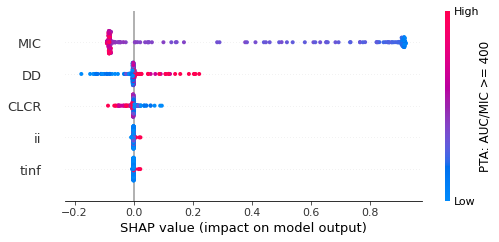

In [ ]:
shap.summary_plot(shap_values, X_train_sample, 
                  color_bar_label='PTA: AUC/MIC >= 400', title = 'Impacto de predictores en PTA', show = False)

plt.gcf()
plt.savefig('013_shapValuesPTA_AUCMIC.pdf')

In [ ]:
shap.plots.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
shap.plots.initjs()
shap.plots.force(explainer.expected_value, shap_values, X_train_sample,
                 feature_names=['DD', 'ii', 'tinf', 'CLCR', 'MIC'])